# TensorNetworks in Neural Networks.

Here, we have a small toy example of how to use a TN inside of a fully connected neural network.

First off, let's install tensornetwork

In [3]:
!pip install tensornetwork

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#tf.enable_v2_behavior()
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("tensorflow")

# TensorNetwork layer definition

Here, we define the TensorNetwork layer we wish to use to replace the fully connected layer. Here, we simply use a 2 node Matrix Product Operator network to replace the normal dense weight matrix.

We TensorNetwork's NCon API to keep the code short.

In [4]:

class TNLayer(tf.keras.layers.Layer):

  def __init__(self):
    super(TNLayer, self).__init__()
    # Create the variables for the layer.
    self.a_var = tf.Variable(tf.random.normal(
            shape=(8, 8, 2), stddev=1.0/16.0),
             name="a", trainable=class)
    self.b_var = tf.Variable(tf.random.normal(shape=(8, 8, 2), stddev=1.0/16.0),
                             name="b", trainable=True)
    self.bias = tf.Variable(tf.zeros(shape=(8, 8)), name="bias", trainable=True)

  def call(self, inputs):
    # Define the contraction.
    # We break it out so we can parallelize a batch using
    # tf.vectorized_map (see below).
    def f(input_vec, a_var, b_var, bias_var):
      # Reshape to a matrix instead of a vector.
      input_vec = tf.reshape(input_vec, (8,8))

      # Now we create the network.
      a = tn.Node(a_var)
      b = tn.Node(b_var)
      x_node = tn.Node(input_vec)
      a[1] ^ x_node[0]
      b[1] ^ x_node[1]
      a[2] ^ b[2]

      # The TN should now look like this
      #   |     |
      #   a --- b
      #    \   /
      #      x

      # Now we begin the contraction.
      c = a @ x_node
      result = (c @ b).tensor

      # To make the code shorter, we also could've used Ncon.
      # The above few lines of code is the same as this:
      # result = tn.ncon([x, a_var, b_var], [[1, 2], [-1, 1, 3], [-2, 2, 3]])

      # Finally, add bias.
      return result + bias_var
  
    # To deal with a batch of items, we can use the tf.vectorized_map
    # function.
    # https://www.tensorflow.org/api_docs/python/tf/vectorized_map
    result = tf.vectorized_map(
        lambda vec: f(vec, self.a_var, self.b_var, self.bias), inputs)
    return tf.nn.swish(tf.reshape(result, (-1, 64)))

# Smaller model
These two models are effectively the same, but notice how the TN layer has nearly 10x fewer parameters.

In [5]:
Dense = tf.keras.layers.Dense
fc_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(64, activation=tf.nn.swish),
     Dense(64, activation=tf.nn.swish),
     Dense(1, activation=None)])
fc_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
_________________________________________________________________


In [6]:
tn_model = tf.keras.Sequential(
    [
     tf.keras.Input(shape=(2,)),
     Dense(64, activation=tf.nn.swish),
     # Here, we replace the dense layer with our MPS.
     TNLayer(),
     Dense(1, activation=None)])
tn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                192       
_________________________________________________________________
tn_layer (TNLayer)           (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


# Training a model

You can train the TN model just as you would a normal neural network model! Here, we give an example of how to do it in Keras.

In [7]:
X = np.concatenate([np.random.randn(20, 2) + np.array([3, 3]), 
             np.random.randn(20, 2) + np.array([-3, -3]), 
             np.random.randn(20, 2) + np.array([-3, 3]), 
             np.random.randn(20, 2) + np.array([3, -3]),])

Y = np.concatenate([np.ones((40)), -np.ones((40))])

In [8]:
tn_model.compile(optimizer="adam", loss="mean_squared_error")
tn_model.fit(X, Y, epochs=300, verbose=1)

Epoch 1/300


/home/jamie/anaconda3/envs/Cirq/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


3/3 [==============================] - 0s 2ms/step - loss: 1.0037
Epoch 2/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9944
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 0.9867
Epoch 4/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9791
Epoch 5/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9706
Epoch 6/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9624
Epoch 7/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9538
Epoch 8/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9436
Epoch 9/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9334
Epoch 10/300
3/3 [==============================] - 0s 2ms/step - loss: 0.9214
Epoch 11/300
3/3 [==============================] - 0s 4ms/step - loss: 0.9084
Epoch 12/300
3/3 [==============================] - 0s 3ms/step - loss: 0.8937
Epoch 13/300
3/3 [==============================] - 0s 2ms/step - loss: 0

Epoch 206/300
3/3 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 207/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0607
Epoch 208/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0602
Epoch 209/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0601
Epoch 210/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0597
Epoch 211/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0593
Epoch 212/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0592
Epoch 213/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0589
Epoch 214/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0589
Epoch 215/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0582
Epoch 216/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0580
Epoch 217/300
3/3 [==============================] - 0s 2ms/step - loss: 0.0578
Epoch 218/300
3/3 [=====================

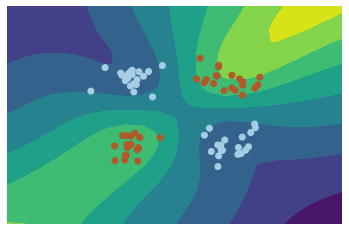

In [11]:
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = tn_model.predict(np.c_[xx.ravel(), yy.ravel()]) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

# VS Fully Connected
Notice how the TN above has a much smoother decision boundary vs the dense network. While the final training loss is slightly worse, the end result is slightly better! Therefore, TN can be used as a form of regularization too!

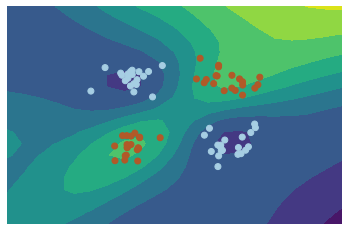

In [12]:
fc_model.compile(optimizer="adam", loss="mean_squared_error")
fc_model.fit(X, Y, epochs=300, verbose=0)
# Plotting code, feel free to ignore.
h = 1.0
x_min, x_max = X[:, 0].min() - 5, X[:, 0].max() + 5
y_min, y_max = X[:, 1].min() - 5, X[:, 1].max() + 5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# here "model" is your model's prediction (classification) function
Z = fc_model.predict(np.c_[xx.ravel(), yy.ravel()]) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis('off')

# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
